Umax = 0.014137442620751043


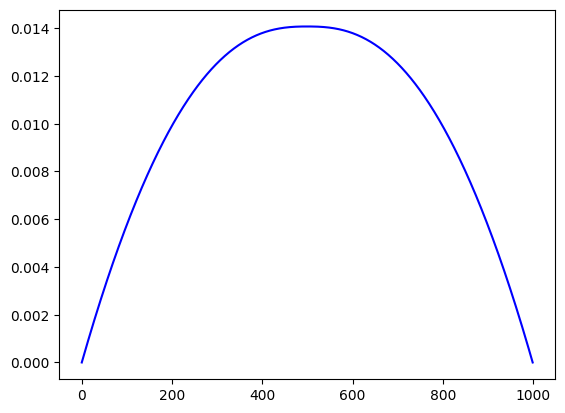

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from math import *
from scipy.integrate import simpson # Changed simps to simpson

# 100 linearly spaced numbers
resolution = 500
z_axis = np.linspace(0, 0.00005, resolution)
velocity = np.zeros(resolution)
gamma = np.zeros(resolution)
tau = np.zeros(resolution)

mu0 = 1.56e-5
mui = 1.56e-6
a = 0.644
n = 0.392
labda = 0.11
dp = 0.0168
Length = 0.0005 # meter
coeff = dp/Length

def my_newton(f, df, x0, tol):
    # output is an estimation of the root of f
    # using the Newton Raphson method
    # recursive implementation
    if abs(f(x0)) < tol:
        return x0
    else:
        return my_newton(f, df, x0 - f(x0)/df(x0), tol)

n_prime = (n-1)/a
mu_prime = mu0-mui
l_prime = labda**a
f_prime = lambda x: mui + mu_prime*(1+l_prime*(x**a))**n_prime + mu_prime*(n-1)*(l_prime*x**a)*((1+l_prime*(x**a))**(n_prime-1))

for z in range(z_axis.size - 1):
    z_loc = z_axis[z+1]
    tau[z+1] = (z_loc*coeff)
    f = lambda x: x*(mui+(mu_prime)*(1+l_prime*(x**a))**(n_prime)) - (z_loc*coeff)
    gamma[z+1] = my_newton(f,f_prime, 0.002, 1e-12)
    velocity[z+1] = simpson(gamma,z_axis) # Changed simps to simpson

gamma = np.flip(gamma)

for z in range(z_axis.size):
    velocity[-z-1] = simpson(gamma[1:z+2],z_axis[1:z+2]) # Changed simps to simpson

print(f'Umax = {simpson(gamma,z_axis)}') # Changed simps to simpson

total = np.concatenate((np.flip(velocity),velocity),axis=None)

np.savetxt("1D-NonNewtonian.csv", total, delimiter=",")
plt.plot(total,'b')
plt.show()

Running baseline solve (this may take a few seconds)...
Baseline computed: u_max = 1.966489e-06 m/s, Q (per depth) = 6.520781e-11 m^2/s
Baseline runtime: 0.01 s

Running Stage-1 sensitivity (±10.0%) for parameters: ['mu0', 'mui', 'lam', 'a', 'n']
Sensitivity runs finished. Time elapsed: 0.14 s
Results saved to sensitivity_stage1_results.csv


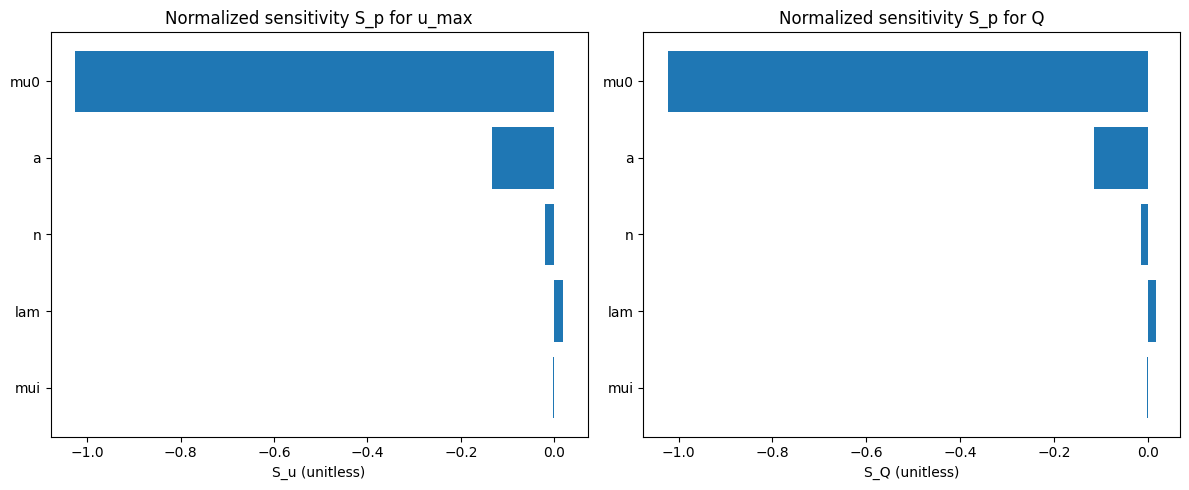


Sensitivity summary (normalized S_p):
parameter     S_u     S_Q
      mu0 -1.0261 -1.0233
      mui -0.0034 -0.0028
      lam  0.0191  0.0157
        a -0.1332 -0.1145
        n -0.0195 -0.0160


In [ ]:
"""
sensitivity_stage1.py

Stage-1 sensitivity analysis (one-factor-at-a-time) for a 1D Carreau-Yasuda solver
(non-Newtonian flow in a channel). For each selected parameter, the script:
  - computes the baseline solution,
  - perturbs the parameter by +delta and -delta (central difference),
  - computes outputs (u_max and Q) for each perturbation,
  - computes normalized sensitivity coefficient S_p.

Outputs:
  - CSV file with sensitivity numbers
  - Tornado-style bar plot showing sensitivities for u_max and Q

Notes:
  - The 1D solver implemented here follows the semi-analytical approach:
      solve for local shear rate gamma(z) from:
          gamma * mu_eff(gamma) = (z * dp) / L
    then integrate gamma from wall->center to get u(z), mirror to get full profile.
  - Units must be consistent (SI). Default baseline parameters taken from the paper's
    Carreau-Yasuda parameters (blood-like) and dp/Length values similar to earlier code.
"""

import numpy as np
from scipy.integrate import cumulative_trapezoid, simpson
import matplotlib.pyplot as plt
import pandas as pd
import time

# ---------------------------
# 1) Physical / numerical setup
# ---------------------------

# Spatial discretization (half-channel from wall to centerline)
N = 500                      # number of points across half-gap
z_max = 50e-6                # half-channel width (m) — 50 microns (example from paper)
z_axis = np.linspace(0, z_max, N)

# Pressure gradient parameters (we use dp and Length as in earlier scripts)
dp = 0.0168                  # pressure difference (Pa) -- example value; ensure correct units
Length = 0.0005              # channel length over which dp is applied (m)
coeff = dp / Length          # convenience: Δp / L

# Baseline Carreau-Yasuda (blood-like) parameters (verify from your code if different)
mu0_base = 0.022             # mu_0 (Pa.s)  -- zero-shear viscosity
mui_base = 0.0022            # mu_infty (Pa.s)
a_base = 0.644               # Yasuda exponent (a)
n_base = 0.392               # power-law index (n)
lambda_base = 0.11           # lambda (s)

# Tolerance & Newton parameters
NEWTON_TOL = 1e-10
NEWTON_MAX_IT = 100

# Output: we compute u_max and Q (per unit depth)
# Q (per unit depth) = 2 * integral_0^{z_max} u(z) dz

# ---------------------------
# 2) Define Carreau-Yasuda mu_eff and its derivative
# ---------------------------

def mu_eff(gamma, mu0, mui, lam, a, n):
    """
    Carreau-Yasuda effective viscosity:
      mu_eff(gamma) = mui + (mu0 - mui) * (1 + (lam*gamma)^a)^{(n-1)/a}
    Inputs:
      gamma : scalar or numpy array (s^-1)
    Returns:
      mu_eff same shape as gamma
    """
    delta_mu = mu0 - mui
    p = (n - 1.0) / a
    return mui + delta_mu * (1.0 + (lam * gamma)**a)**p

def dmu_eff_dgamma(gamma, mu0, mui, lam, a, n):
    """
    Analytic derivative d(mu_eff)/d(gamma).
    From:
      mu_eff = mui + Δμ * (1 + (λγ)^a)^p,  p = (n-1)/a
    dmu/dgamma = Δμ * p * (1 + (λγ)^a)^{p-1} * a * λ^a * γ^{a-1}
    """
    delta_mu = mu0 - mui
    p = (n - 1.0) / a
    # handle gamma == 0 safely: gamma^(a-1) may be singular for a<1 -> treat as limit 0
    # but in practice gamma=0 => derivative is 0 (since term has gamma^{a-1} multiplied by gamma later).
    # We'll compute using numpy safely.
    inner = 1.0 + (lam * gamma)**a
    return delta_mu * p * (inner**(p - 1.0)) * (a * (lam**a) * np.where(gamma == 0, 0.0, gamma**(a - 1.0)))

# ---------------------------
# 3) Solve local nonlinear equation for gamma(z) pointwise using Newton
#    F(gamma) = gamma * mu_eff(gamma) - C  where C = z * coeff
# ---------------------------

def solve_gamma_for_z(z_val, mu0, mui, lam, a, n, coeff, gamma_init=None):
    """
    Solve F(gamma) = gamma * mu_eff(gamma) - C = 0 for gamma >= 0 using Newton.
    Inputs:
      z_val : scalar z at which to evaluate (m)
      ... rheological params ...
      coeff : dp / L
      gamma_init : initial guess (if None, uses 1e-3)
    Returns:
      gamma (scalar, s^-1)
    """
    C = z_val * coeff
    # If C == 0, then gamma == 0 is the root
    if C == 0.0:
        return 0.0

    # initial guess: use provided or small positive
    if gamma_init is None:
        gamma = 1e-3  # s^-1
    else:
        gamma = float(max(1e-12, gamma_init))  # ensure positive

    for it in range(NEWTON_MAX_IT):
        mu = mu_eff(gamma, mu0, mui, lam, a, n)
        dmu = dmu_eff_dgamma(gamma, mu0, mui, lam, a, n)
        F = gamma * mu - C
        # derivative F' = mu + gamma * dmu
        Fp = mu + gamma * dmu
        # guard against zero derivative
        if abs(Fp) < 1e-16:
            # fallback small perturbation and continue
            gamma += 1e-12
            continue
        # Newton step
        delta = F / Fp
        gamma_new = gamma - delta
        # ensure positivity
        if gamma_new < 0:
            gamma_new = gamma * 0.5  # damp and keep positive
        # check convergence in residual
        if abs(F) < NEWTON_TOL:
            return gamma_new
        # update
        gamma = gamma_new
    # if not converged, warn (but return current)
    # print(f"[warn] Newton did not converge at z={z_val:.3e}; last residual={F:.3e}")
    return gamma

# ---------------------------
# 4) Full solver: gamma(z) across half-gap, then integrate to get velocity u(z)
# ---------------------------

def solve_1d_profile(mu0, mui, lam, a, n, coeff, z_axis):
    """
    Solve gamma(z) on half-gap z_axis (0..z_max), then compute u(z) by integrating gamma.
    Returns:
      z_axis, gamma_half, u_half (arrays of length len(z_axis))
    Note: u(0)=0 at wall; u is computed from wall->center by cumulative integral:
          u(z) = integral_0^z gamma(z') dz'
    """
    N = len(z_axis)
    gamma = np.zeros(N)
    # Use continuation: initial guess for each z is previous gamma (smooth)
    prev_guess = 1e-3
    for i in range(N):
        z_val = z_axis[i]
        # skip i==0 (z=0) which yields gamma=0
        if z_val == 0.0:
            gamma[i] = 0.0
            prev_guess = 1e-6
            continue
        g = solve_gamma_for_z(z_val, mu0, mui, lam, a, n, coeff, gamma_init=prev_guess)
        gamma[i] = g
        prev_guess = g
    # integrate gamma to get u (half profile). use cumulative trapezoid via cumulative_trapezoid
    u_half = cumulative_trapezoid(gamma, z_axis, initial=0.0)  # u(0)=0
    return gamma, u_half

# ---------------------------
# 5) Compute outputs: u_max and Q (per unit depth)
# ---------------------------

def compute_outputs(gamma_half, u_half, z_axis):
    """
    Given half-gap gamma and u, compute:
      - u_max (scalar) = u_half[-1] (centerline)
      - Q_per_depth = 2 * integral_0^{z_max} u(z) dz  (per unit depth)
    Returns (u_max, Q_per_depth)
    """
    u_max = u_half[-1]
    Q_half = simpson(u_half, z_axis)   # integral over half-gap
    Q = 2.0 * Q_half                 # symmetric full channel (per unit depth into page)
    return u_max, Q

# ---------------------------
# 6) Sensitivity computation (central finite difference)
# ---------------------------

def sensitivity_analysis_one_at_a_time(params_baseline, param_names, perturb_frac, z_axis, coeff):
    """
    params_baseline: dict of baseline params: {'mu0':..., 'mui':..., 'lam':..., 'a':..., 'n':...}
    param_names: list of keys from params_baseline to perturb one-by-one
    perturb_frac: relative perturbation (e.g., 0.1 for +/-10%)
    Returns:
      pandas DataFrame with baseline outputs and sensitivities S_p for each parameter (for u_max and Q)
    """
    # compute baseline outputs
    gamma_base, u_base = solve_1d_profile(params_baseline['mu0'], params_baseline['mui'],
                                         params_baseline['lam'], params_baseline['a'],
                                         params_baseline['n'], coeff, z_axis)
    umax_base, Q_base = compute_outputs(gamma_base, u_base, z_axis)

    results = []
    for pname in param_names:
        p0 = params_baseline[pname]
        delta = p0 * perturb_frac
        p_plus = p0 + delta
        p_minus = p0 - delta

        # prepare param dicts for runs
        params_plus = params_baseline.copy()
        params_minus = params_baseline.copy()
        params_plus[pname] = p_plus
        params_minus[pname] = p_minus

        # run plus
        gamma_p, u_p = solve_1d_profile(params_plus['mu0'], params_plus['mui'],
                                        params_plus['lam'], params_plus['a'],
                                        params_plus['n'], coeff, z_axis)
        umax_p, Q_p = compute_outputs(gamma_p, u_p, z_axis)

        # run minus
        gamma_m, u_m = solve_1d_profile(params_minus['mu0'], params_minus['mui'],
                                        params_minus['lam'], params_minus['a'],
                                        params_minus['n'], coeff, z_axis)
        umax_m, Q_m = compute_outputs(gamma_m, u_m, z_axis)

        # central finite difference derivative dO/dp ≈ (O+ - O-) / (2 Δp)
        dUmax_dp = (umax_p - umax_m) / (2.0 * delta)
        dQ_dp    = (Q_p - Q_m) / (2.0 * delta)

        # normalized sensitivity S_p = (dO/dp) * (p0 / O_base)
        S_u = dUmax_dp * (p0 / umax_base) if umax_base != 0 else np.nan
        S_Q = dQ_dp * (p0 / Q_base) if Q_base != 0 else np.nan

        results.append({
            'parameter': pname,
            'p0': p0,
            'delta': delta,
            'umax_base': umax_base,
            'Q_base': Q_base,
            'umax_plus': umax_p,
            'umax_minus': umax_m,
            'Q_plus': Q_p,
            'Q_minus': Q_m,
            'dUmax_dp': dUmax_dp,
            'dQ_dp': dQ_dp,
            'S_u': S_u,
            'S_Q': S_Q
        })

    df = pd.DataFrame(results)
    return df

# ---------------------------
# 7) Main execution: run baseline + sensitivity, save results, plot tornado
# ---------------------------

def main():
    # Baseline parameter dictionary
    params_baseline = {
        'mu0': mu0_base,
        'mui': mui_base,
        'lam': lambda_base,
        'a': a_base,
        'n': n_base
    }

    # parameters to test (one-at-a-time)
    param_names = ['mu0', 'mui', 'lam', 'a', 'n']

    # Set perturbation fraction (±10% central)
    perturb_frac = 0.10

    print("Running baseline solve (this may take a few seconds)...")
    t0 = time.time()
    gamma_base, u_base = solve_1d_profile(params_baseline['mu0'], params_baseline['mui'],
                                         params_baseline['lam'], params_baseline['a'],
                                         params_baseline['n'], coeff, z_axis)
    umax_base, Q_base = compute_outputs(gamma_base, u_base, z_axis)
    t1 = time.time()
    print(f"Baseline computed: u_max = {umax_base:.6e} m/s, Q (per depth) = {Q_base:.6e} m^2/s")
    print(f"Baseline runtime: {t1 - t0:.2f} s")

    print(f"\nRunning Stage-1 sensitivity (±{perturb_frac*100:.1f}%) for parameters: {param_names}")
    tstart = time.time()
    df_sens = sensitivity_analysis_one_at_a_time(params_baseline, param_names, perturb_frac, z_axis, coeff)
    tend = time.time()
    print(f"Sensitivity runs finished. Time elapsed: {tend - tstart:.2f} s")

    # Save full results to CSV
    out_csv = "sensitivity_stage1_results.csv"
    df_sens.to_csv(out_csv, index=False)
    print(f"Results saved to {out_csv}")

    # Present a tornado plot for S_u and S_Q
    # sort parameters by absolute sensitivity for u_max
    df_plot = df_sens.copy()
    df_plot['abs_S_u'] = np.abs(df_plot['S_u'])
    df_plot = df_plot.sort_values('abs_S_u', ascending=True)

    # Create figure with two horizontal bar charts side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].barh(df_plot['parameter'], df_plot['S_u'])
    axes[0].set_title('Normalized sensitivity S_p for u_max')
    axes[0].set_xlabel('S_u (unitless)')

    # sort by abs for Q
    df_plot_q = df_sens.copy()
    df_plot_q['abs_S_Q'] = np.abs(df_plot_q['S_Q'])
    df_plot_q = df_plot_q.sort_values('abs_S_Q', ascending=True)
    axes[1].barh(df_plot_q['parameter'], df_plot_q['S_Q'])
    axes[1].set_title('Normalized sensitivity S_p for Q')
    axes[1].set_xlabel('S_Q (unitless)')

    plt.tight_layout()
    plt.savefig("sensitivity_tornado.png", dpi=300)
    plt.show()

    # Print table of sensitivities
    print("\nSensitivity summary (normalized S_p):")
    print(df_sens[['parameter', 'S_u', 'S_Q']].to_string(index=False, float_format=lambda x: f"{x:.4f}"))

if __name__ == "__main__":
    main()

In [ ]:
!pip install SALib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.1/780.1 kB 11.2 MB/s eta 0:00:00


Generating Morris samples...
Total samples to run: 240
Eval 50/240  elapsed 0.6s
Eval 100/240  elapsed 1.3s
Eval 150/240  elapsed 2.2s
Eval 200/240  elapsed 3.1s
Eval 240/240  elapsed 3.7s
Total model evaluations done in 3.7s
Analyzing Morris results for u_max...
Analyzing Morris results for Q...
Morris results saved to morris_stage2_results.csv


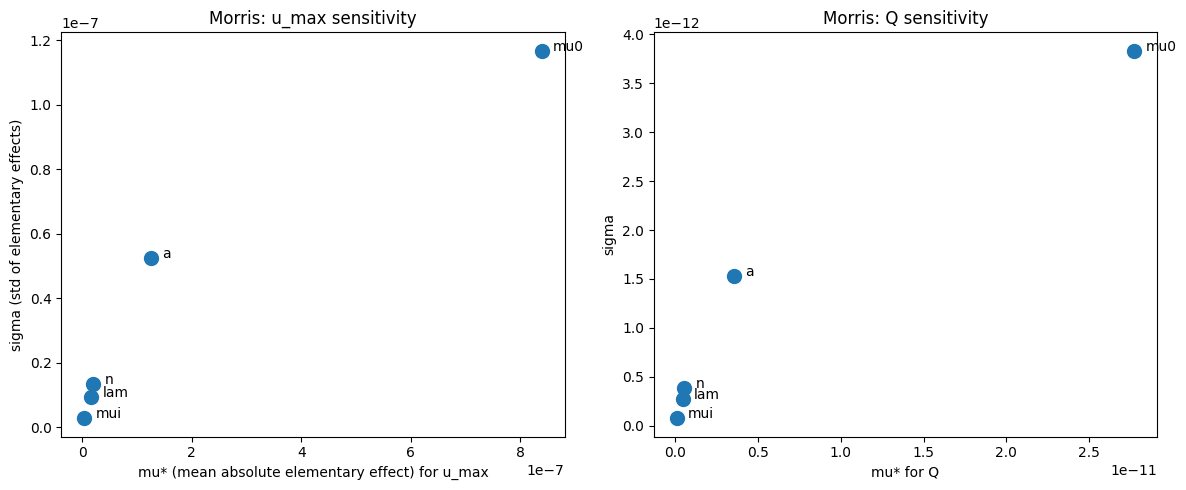


Morris summary (mu* and sigma):
parameter mu_star_u  sigma_u mu_star_Q  sigma_Q
      mu0  0.000001 0.000000  0.000000 0.000000
      mui  0.000000 0.000000  0.000000 0.000000
      lam  0.000000 0.000000  0.000000 0.000000
        a  0.000000 0.000000  0.000000 0.000000
        n  0.000000 0.000000  0.000000 0.000000


In [ ]:
"""
sensitivity_stage2_morris.py

Stage-2 sensitivity analysis using the Morris method (elementary effects)
for the 1D Carreau-Yasuda solver (non-Newtonian channel flow).

Outputs:
 - CSV files with results per parameter for u_max and Q
 - Scatter plot (mu* vs sigma) for each output to identify important and nonlinear parameters
"""

import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

from scipy.integrate import cumulative_trapezoid, simpson # Changed cumtrapz to cumulative_trapezoid and simps to simpson

# SALib imports
from SALib.sample import morris
from SALib.analyze import morris as morris_analyze

# ---------------------------
# 1) Problem definition & base parameters
# ---------------------------

# Spatial discretization (half channel)
N = 500
z_max = 50e-6
z_axis = np.linspace(0.0, z_max, N)

# Pressure gradient / geometry - ensure these match your baseline
dp = 0.0168
Length = 0.0005
coeff = dp / Length

# Baseline Carreau-Yasuda parameters (verify these match your data)
mu0_base  = 0.022    # Pa.s
mui_base  = 0.0022   # Pa.s
lam_base  = 0.11     # s
a_base    = 0.644
n_base    = 0.392

# Parameter names we will analyze (order matters for SALib)
param_names = ['mu0', 'mui', 'lam', 'a', 'n']

# Define parameter bounds for Morris sampling:
# Use +/- 20% around baseline as a reasonable exploratory range
frac = 0.20
bounds = [
    [mu0_base * (1 - frac), mu0_base * (1 + frac)],
    [mui_base * (1 - frac), mui_base * (1 + frac)],
    [lam_base * (1 - frac), lam_base * (1 + frac)],
    [a_base   * (1 - frac), a_base   * (1 + frac)],
    [n_base   * (1 - frac), n_base   * (1 + frac)]
]

# SALib problem dict
problem = {
    'num_vars': len(param_names),
    'names': param_names,
    'bounds': bounds
}

# Morris sampling parameters
N_trajectories = 40   # you can increase/decrease depending on time/accuracy
num_levels = 4        # grid levels (common choices: 4,6,8)
# grid_jump = 1         # typical small jump - REMOVED AS PER ERROR, BUT KEPT FOR REFERENCE

# ---------------------------
# 2) Carreau-Yasuda helper functions (same math as Stage-1)
# ---------------------------

def mu_eff(gamma, mu0, mui, lam, a, n):
    delta_mu = mu0 - mui
    p = (n - 1.0) / a
    return mui + delta_mu * (1.0 + (lam * gamma)**a)**p

def dmu_eff_dgamma(gamma, mu0, mui, lam, a, n):
    delta_mu = mu0 - mui
    p = (n - 1.0) / a
    inner = 1.0 + (lam * gamma)**a
    # avoid gamma==0 singularity by np.where; derivative near zero is effectively 0
    # gamma**(a-1) can blow for a<1; using where to set 0 at gamma==0
    return delta_mu * p * (inner**(p - 1.0)) * (a * (lam**a) * np.where(gamma == 0, 0.0, gamma**(a - 1.0)))

# Newton solver for gamma (pointwise)
NEWTON_TOL = 1e-10
NEWTON_MAX_IT = 100

def solve_gamma_for_z(z_val, mu0, mui, lam, a, n, coeff, gamma_init=None):
    C = z_val * coeff
    if C == 0:
        return 0.0
    if gamma_init is None:
        gamma = 1e-3
    else:
        gamma = max(1e-12, float(gamma_init))
    for it in range(NEWTON_MAX_IT):
        mu = mu_eff(gamma, mu0, mui, lam, a, n)
        dmu = dmu_eff_dgamma(gamma, mu0, mui, lam, a, n)
        F = gamma * mu - C
        Fp = mu + gamma * dmu
        if abs(Fp) < 1e-16:
            gamma += 1e-12
            continue
        delta = F / Fp
        gamma_new = gamma - delta
        if gamma_new < 0:
            gamma_new = gamma * 0.5
        if abs(F) < NEWTON_TOL:
            return gamma_new
        gamma = gamma_new
    return gamma

# Solve full half-profile and integrate
def solve_1d_profile(mu0, mui, lam, a, n, coeff, z_axis):
    N = len(z_axis)
    gamma = np.zeros(N)
    prev_guess = 1e-3
    for i in range(N):
        z_val = z_axis[i]
        if z_val == 0:
            gamma[i] = 0.0
            prev_guess = 1e-6
            continue
        g = solve_gamma_for_z(z_val, mu0, mui, lam, a, n, coeff, gamma_init=prev_guess)
        gamma[i] = g
        prev_guess = g
    u_half = cumulative_trapezoid(gamma, z_axis, initial=0.0) # Changed cumtrapz to cumulative_trapezoid
    return gamma, u_half

def compute_outputs(gamma_half, u_half, z_axis):
    u_max = u_half[-1]
    Q_half = simpson(u_half, z_axis) # Changed simps to simpson
    Q = 2.0 * Q_half
    return u_max, Q

# Wrapper that SALib will use (given a parameter vector)
def model_run(x):
    """
    x: array-like [mu0, mui, lam, a, n]
    returns: two outputs (u_max, Q)
    """
    mu0, mui, lam, a, n = x
    gamma_half, u_half = solve_1d_profile(mu0, mui, lam, a, n, coeff, z_axis)
    u_max, Q = compute_outputs(gamma_half, u_half, z_axis)
    return u_max, Q

# ---------------------------
# 3) Build Morris samples and evaluate model
# ---------------------------

def run_morris_and_analyze():
    # Generate Morris sample matrix
    # SALib's morris.sample takes parameters: problem, N, num_levels
    print("Generating Morris samples...")
    param_values = morris.sample(problem, N_trajectories, num_levels=num_levels)
    # param_values shape: (num_samples, num_vars) where num_samples = N*(k+1)
    print(f"Total samples to run: {param_values.shape[0]}")

    # Pre-allocate result arrays
    Y_u = np.zeros(param_values.shape[0])
    Y_Q = np.zeros(param_values.shape[0])

    # Evaluate model for every sample
    t0 = time.time()
    for i, x in enumerate(param_values):
        u_max, Q = model_run(x)
        Y_u[i] = u_max
        Y_Q[i] = Q
        # Optional: print progress occasionally
        if (i+1) % 50 == 0 or (i+1) == param_values.shape[0]:
            elapsed = time.time() - t0
            print(f"Eval {i+1}/{param_values.shape[0]}  elapsed {elapsed:.1f}s")
    total_time = time.time() - t0
    print(f"Total model evaluations done in {total_time:.1f}s")

    # ---------------------------
    # 4) Run Morris analysis for each output
    # ---------------------------
    print("Analyzing Morris results for u_max...")
    Si_u = morris_analyze.analyze(problem, param_values, Y_u, conf_level=0.95,
                                  print_to_console=False, num_levels=num_levels)
    print("Analyzing Morris results for Q...")
    Si_Q = morris_analyze.analyze(problem, param_values, Y_Q, conf_level=0.95,
                                  print_to_console=False, num_levels=num_levels)

    # Si_* is a dict containing keys: mu (mean), mu_star (mean absolute), sigma (std), etc.
    # We'll extract mu_star and sigma
    results = []
    for idx, name in enumerate(param_names):
        results.append({
            'parameter': name,
            'mu_star_u': Si_u['mu_star'][idx],
            'sigma_u': Si_u['sigma'][idx],
            'mu_star_Q': Si_Q['mu_star'][idx],
            'sigma_Q': Si_Q['sigma'][idx]
        })

    df = pd.DataFrame(results)
    df_sorted_u = df.sort_values('mu_star_u', ascending=False)
    df_sorted_q = df.sort_values('mu_star_Q', ascending=False)

    # Save CSV
    df.to_csv("morris_stage2_results.csv", index=False)
    print("Morris results saved to morris_stage2_results.csv")

    # ---------------------------
    # 5) Plot mu* vs sigma for each output (scatter with labels)
    # ---------------------------
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    # u_max plot
    axes[0].scatter(df['mu_star_u'], df['sigma_u'], s=100)
    for i, row in df.iterrows():
        axes[0].annotate(row['parameter'], (row['mu_star_u'], row['sigma_u']), textcoords="offset points", xytext=(8,0))
    axes[0].set_xlabel("mu* (mean absolute elementary effect) for u_max")
    axes[0].set_ylabel("sigma (std of elementary effects)")
    axes[0].set_title("Morris: u_max sensitivity")

    # Q plot
    axes[1].scatter(df['mu_star_Q'], df['sigma_Q'], s=100)
    for i, row in df.iterrows():
        axes[1].annotate(row['parameter'], (row['mu_star_Q'], row['sigma_Q']), textcoords="offset points", xytext=(8,0))
    axes[1].set_xlabel("mu* for Q")
    axes[1].set_ylabel("sigma")
    axes[1].set_title("Morris: Q sensitivity")

    plt.tight_layout()
    plt.savefig("morris_mu_vs_sigma.png", dpi=300)
    plt.show()

    # Print table to console
    print("\nMorris summary (mu* and sigma):")
    print(df.to_string(index=False, formatters={
        'mu_star_u': '{:.6f}'.format,
        'sigma_u': '{:.6f}'.format,
        'mu_star_Q': '{:.6f}'.format,
        'sigma_Q': '{:.6f}'.format
    }))

    return df, Si_u, Si_Q

if __name__ == "__main__":
    df, Si_u, Si_Q = run_morris_and_analyze()


Running baseline concentration + AMI...
Baseline AMI = 7.124066e-01 (computed in 0.00 s)
Running Stage-1 sensitivity (±10.0%) for parameters: ['speed', 'diffusion', 'length', 'width']
Completed sensitivity runs in 0.02 s
Saved sensitivity table to mixing_sensitivity_stage1_results.csv

Sensitivity summary (normalized S_p):
parameter       S_p
    speed  0.242222
diffusion -0.240561
   length -0.240561
    width  0.487186


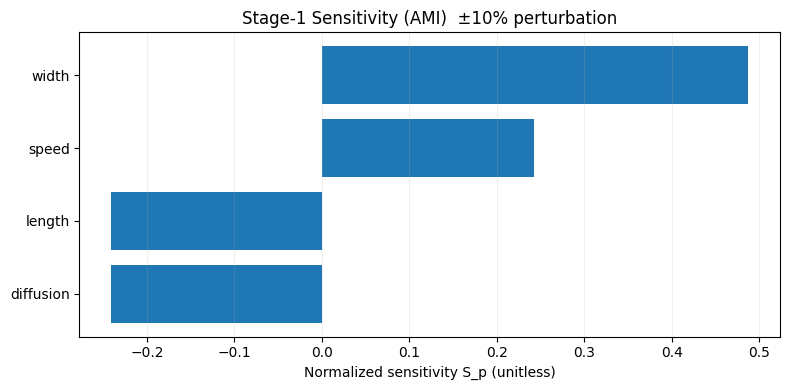

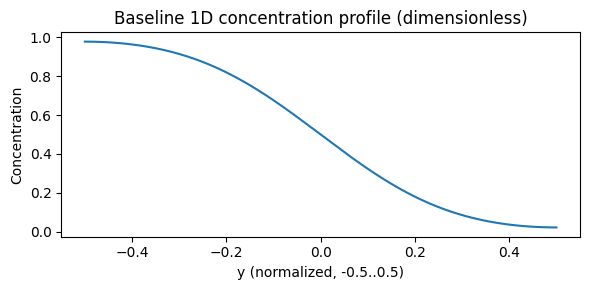

In [ ]:
"""
mixing_sensitivity_stage1.py

Stage-1 sensitivity analysis (one-factor-at-a-time) for the 1D diffusion-advection mixing model.
Uses the series solution implemented in the user's snippet and computes AMI as the output.

Outputs:
 - CSV with baseline and +/- perturbed AMI values and computed sensitivities
 - Tornado bar plot of normalized sensitivity S_p for AMI
"""

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from math import sin, cos, exp, pi

# -------------------------
# Utility: AMI computation
# -------------------------
def compute_AMI(data):
    """
    Compute Absolute Mixing Index as sigma / mean
    (same as in user's code).
    """
    sigma = np.std(data)
    average = np.average(data)
    # avoid division by zero
    return sigma / average if average != 0 else np.nan

# -------------------------
# Core: 1D analytical concentration via series
# -------------------------
def concentration_1d_series(length, width, speed, diffusion,
                            y_axis, tol=1e-8, max_terms=10000):
    """
    Compute concentration profile using the series solution (same logic as user's snippet).
    Inputs:
      length, width: geometry in meters
      speed: flow velocity (m/s)
      diffusion: molecular diffusion coefficient D (m^2/s)
      y_axis: 1D numpy array of y positions normalized to channel width range [-0.5, 0.5]
      tol: term truncation tolerance for series multiplier
      max_terms: safety cap on number of terms
    Returns:
      concentration: numpy array (same length as y_axis) with concentration values in [0,1]
    Notes:
      - Assumes inlet concentration is 0 and 1 on two halves then uses the analytical series.
      - Uses dimensionless x = length / width and Péclet Pe = (U * width) / D
      - The returned concentration matches user's formula (after the final 1 - concentration step)
    """
    # initialize concentration to 0.5 baseline (as in original code)
    concentration = np.zeros_like(y_axis) + 0.5

    # dimensionless variables
    x_dimless = length / width
    Pe = (speed * width) / diffusion

    # series summation: n = 1,3,5,... (i.e., odd integers)
    n = 1
    term_count = 0
    while term_count < max_terms:
        k = 2 * n - 1  # odd index
        coeff = exp(-(x_dimless * (pi**2) * (k**2)) / Pe)
        # break if term is negligibly small
        if coeff < tol:
            break
        product = ((1 - cos(pi * k)) / k)
        # update concentration according to series
        # c += (sin(pi*k*y) * product * coeff) / pi
        # vectorized for all y positions
        s = np.sin(pi * k * y_axis)
        concentration += (s * product * coeff) / pi
        n += 1
        term_count += 1

    # final transformation used in user's code
    concentration = 1.0 - concentration
    return concentration

# -------------------------
# Helper that returns AMI given parameters
# -------------------------
def compute_AMI_from_params(params, y_axis, series_tol=1e-8):
    """
    params: dict with keys 'length', 'width', 'speed', 'diffusion'
    returns: concentration array, AMI scalar
    """
    conc = concentration_1d_series(params['length'], params['width'],
                                   params['speed'], params['diffusion'],
                                   y_axis, tol=series_tol)
    ami = compute_AMI(conc)
    return conc, ami

# -------------------------
# Sensitivity stage-1: central finite difference for AMI
# -------------------------
def sensitivity_stage1_mix(baseline_params, param_names, perturb_frac,
                           y_axis, series_tol=1e-8):
    """
    baseline_params: dict with baseline numeric values
    param_names: list of keys in baseline_params to perturb (strings)
    perturb_frac: fraction for +/- perturbation (e.g., 0.10 for 10%)
    y_axis: discretized y positions for concentration profile
    Returns:
      pandas.DataFrame with baseline and perturbed AMIs and computed S_p
    """
    # baseline run
    _, ami_base = compute_AMI_from_params(baseline_params, y_axis, series_tol)
    results = []

    for pname in param_names:
        p0 = baseline_params[pname]
        delta = p0 * perturb_frac
        p_plus = p0 + delta
        p_minus = p0 - delta

        # form parameter dictionaries
        p_plus_dict = baseline_params.copy()
        p_minus_dict = baseline_params.copy()
        p_plus_dict[pname] = p_plus
        p_minus_dict[pname] = p_minus

        # compute AMIs
        _, ami_p = compute_AMI_from_params(p_plus_dict, y_axis, series_tol)
        _, ami_m = compute_AMI_from_params(p_minus_dict, y_axis, series_tol)

        # numerical derivative
        dO_dp = (ami_p - ami_m) / (2.0 * delta)

        # normalized sensitivity: (dO/dp) * (p0 / O_base)
        S_p = dO_dp * (p0 / ami_base) if ami_base != 0 else np.nan

        results.append({
            'parameter': pname,
            'p0': p0,
            'delta': delta,
            'AMI_base': ami_base,
            'AMI_plus': ami_p,
            'AMI_minus': ami_m,
            'dAMI_dp': dO_dp,
            'S_p': S_p
        })

    df = pd.DataFrame(results)
    return df

# -------------------------
# Main: user-configurable baseline and plotting
# -------------------------
def main():
    # 1. Discretization for concentration along width (same as user's code)
    resolution = 1000
    y_axis = np.linspace(-0.5, 0.5, resolution)  # dimensionless across channel width

    # 2. Baseline parameters (change to match your experimental / paper values if needed)
    baseline_params = {
        'length': 0.000860,    # meters
        'width' : 0.000060,    # meters
        'speed' : 0.01,        # m/s (inlet velocity)
        'diffusion': 1e-9      # m^2/s
    }

    # Which parameters to perturb
    param_names = ['speed', 'diffusion', 'length', 'width']

    # perturbation fraction for central finite difference (10% default)
    perturb_frac = 0.10

    # series tolerance (controls how many terms are summed)
    series_tol = 1e-10

    print("Running baseline concentration + AMI...")
    t0 = time.time()
    conc_base, ami_base = compute_AMI_from_params(baseline_params, y_axis, series_tol)
    t1 = time.time()
    print(f"Baseline AMI = {ami_base:.6e} (computed in {t1-t0:.2f} s)")

    # Run sensitivity
    print(f"Running Stage-1 sensitivity (±{perturb_frac*100:.1f}%) for parameters: {param_names}")
    tstart = time.time()
    df_sens = sensitivity_stage1_mix(baseline_params, param_names, perturb_frac, y_axis, series_tol)
    tend = time.time()
    print(f"Completed sensitivity runs in {tend - tstart:.2f} s")

    # Save results
    out_csv = "mixing_sensitivity_stage1_results.csv"
    df_sens.to_csv(out_csv, index=False)
    print(f"Saved sensitivity table to {out_csv}")

    # Print summary table
    print("\nSensitivity summary (normalized S_p):")
    print(df_sens[['parameter','S_p']].to_string(index=False, float_format=lambda x: f"{x:.6f}"))

    # Tornado plot (single-bar since only AMI output)
    df_plot = df_sens.copy()
    # order by absolute sensitivity
    df_plot['abs_Sp'] = df_plot['S_p'].abs()
    df_plot = df_plot.sort_values('abs_Sp', ascending=True)

    plt.figure(figsize=(8,4))
    plt.barh(df_plot['parameter'], df_plot['S_p'], color='C0')
    plt.xlabel('Normalized sensitivity S_p (unitless)')
    plt.title(f'Stage-1 Sensitivity (AMI)  ±{perturb_frac*100:.0f}% perturbation')
    plt.grid(axis='x', alpha=0.2)
    plt.tight_layout()
    plt.savefig("mixing_sensitivity_tornado.png", dpi=300)
    plt.show()

    # Optional: plot baseline concentration profile
    plt.figure(figsize=(6,3))
    plt.plot(y_axis, conc_base)
    plt.xlabel('y (normalized, -0.5..0.5)')
    plt.ylabel('Concentration')
    plt.title('Baseline 1D concentration profile (dimensionless)')
    plt.tight_layout()
    plt.savefig("mixing_baseline_profile.png", dpi=300)
    plt.show()

if __name__ == "__main__":
    main()


Generating Morris samples...
Total model evaluations to run: 200
Evaluations: 50/200  elapsed 0.0s
Evaluations: 100/200  elapsed 0.0s
Evaluations: 150/200  elapsed 0.0s
Evaluations: 200/200  elapsed 0.0s
All evaluations completed in 0.0s
Analyzing Morris results (AMI)...
Morris results saved to mixing_morris_results.csv


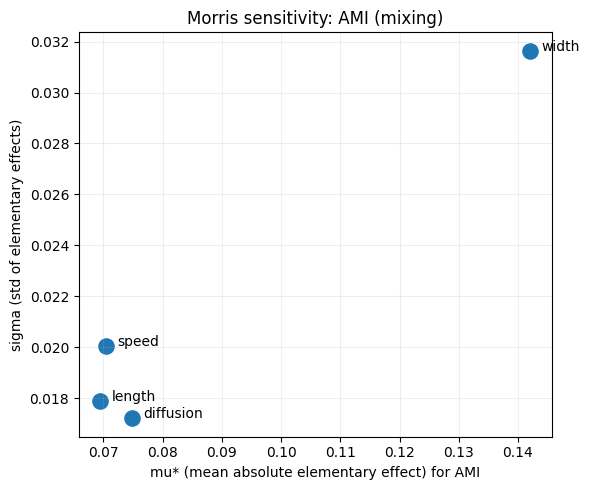


Morris summary (mu* and sigma):
parameter      mu_star        sigma
    width 1.420548e-01 3.164083e-02
diffusion 7.488298e-02 1.721011e-02
    speed 7.048125e-02 2.005648e-02
   length 6.951149e-02 1.788058e-02


In [ ]:
"""
mixing_sensitivity_stage2_morris.py

Stage-2 sensitivity analysis (Morris method) for the 1D diffusion-advection mixing model.
- Builds Morris samples for parameters [speed, diffusion, length, width]
- Evaluates AMI (Absolute Mixing Index) for each sample via the 1D series solution
- Computes Morris mu* and sigma for AMI
- Saves results (CSV) and plots mu* vs sigma scatter

Usage:
    python mixing_stage2_morris.py
"""

import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from math import pi, sin, cos, exp

# SALib imports
from SALib.sample import morris
from SALib.analyze import morris as morris_analyze

# -------------------------
# 1) Settings: domain discretization & baseline params
# -------------------------
# Discretization across normalized channel width (-0.5 .. 0.5)
RESOLUTION = 1000
y_axis = np.linspace(-0.5, 0.5, RESOLUTION)

# Baseline physical parameters (change to match your experiment/paper if needed)
baseline = {
    'speed': 0.01,       # m/s (U)
    'diffusion': 1e-9,   # m^2/s (D)
    'length': 0.000860,  # m (L)
    'width': 0.000060    # m (W)
}

# Morris sampling settings (tune as needed)
N_TRAJECTORIES = 40   # number of base trajectories (higher -> more stable estimates)
NUM_LEVELS = 4        # grid levels (common choices: 4,6,8)
# GRID_JUMP = 1         # typical small jump - REMOVED, WAS CAUSING TYPEERROR
FRAC = 0.20           # parameter bounds ±20% around baseline

# Series truncation tolerance and safety cap
SERIES_TOL = 1e-10
MAX_TERMS = 20000

# Output filenames
CSV_OUT = "mixing_morris_results.csv"
PLOT_OUT = "mixing_morris_mu_vs_sigma.png"

# -------------------------
# 2) Helper functions: concentration series and AMI
# -------------------------
def concentration_1d_series(length, width, speed, diffusion, y_axis,
                            tol=SERIES_TOL, max_terms=MAX_TERMS):
    """
    Compute concentration profile (dimensionless) using the series solution:
      c(y) = 0.5 + (1/pi) * sum_{k odd} [ sin(pi*k*y) * ((1-cos(pi*k))/k) * exp(-x*pi^2*k^2 / Pe) ]
    where x = length/width and Pe = (U * width) / D.
    Final transformation used in user's snippet: c_final = 1 - c.
    Inputs:
      length, width, speed, diffusion : floats (SI units)
      y_axis : numpy array of normalized y positions [-0.5..0.5]
    Returns:
      concentration array (same shape as y_axis)
    """
    # start from 0.5 baseline
    concentration = np.full_like(y_axis, 0.5, dtype=float)

    # dimensionless parameters
    x_dimless = length / width
    Pe = (speed * width) / diffusion
    if Pe <= 0:
        raise ValueError("Peclet number must be > 0 (check speed, width, diffusion)")

    # sum series for odd k = 1,3,5,...
    k_index = 1
    n_terms = 0
    while n_terms < max_terms:
        coeff = exp(-(x_dimless * (pi**2) * (k_index**2)) / Pe)
        # break if contribution negligibly small
        if coeff < tol:
            break
        product = ((1.0 - cos(pi * k_index)) / k_index)
        s = np.sin(pi * k_index * y_axis)
        concentration += (s * product * coeff) / pi
        k_index += 2
        n_terms += 1

    concentration = 1.0 - concentration  # final transform (per original code)
    return concentration

def compute_AMI_from_conc(conc):
    """
    Compute Absolute Mixing Index: std(conc) / mean(conc)
    """
    mean = np.mean(conc)
    std = np.std(conc)
    return std / mean if mean != 0 else np.nan

def compute_AMI(params):
    """
    Wrapper: params is dict with keys 'length','width','speed','diffusion'
    returns AMI scalar and concentration array
    """
    conc = concentration_1d_series(params['length'], params['width'],
                                   params['speed'], params['diffusion'],
                                   y_axis)
    ami = compute_AMI_from_conc(conc)
    return ami, conc

# -------------------------
# 3) SALib problem definition for Morris
# -------------------------
param_names = ['speed', 'diffusion', 'length', 'width']
bounds = [
    [baseline['speed'] * (1 - FRAC), baseline['speed'] * (1 + FRAC)],
    [baseline['diffusion'] * (1 - FRAC), baseline['diffusion'] * (1 + FRAC)],
    [baseline['length'] * (1 - FRAC), baseline['length'] * (1 + FRAC)],
    [baseline['width'] * (1 - FRAC), baseline['width'] * (1 + FRAC)]
]
problem = {'num_vars': len(param_names), 'names': param_names, 'bounds': bounds}

# -------------------------
# 4) Model wrapper for SALib evaluations
# -------------------------
def model_run(x):
    """
    Input x: array-like in the order of param_names [speed, diffusion, length, width]
    Returns single scalar output: AMI
    """
    params = dict(zip(param_names, x))
    ami, _ = compute_AMI(params)
    return ami

# -------------------------
# 5) Main routine: generate samples, evaluate, analyze Morris indices
# -------------------------
def run_morris_mixing():
    # Generate Morris sampling matrix
    print("Generating Morris samples...")
    param_values = morris.sample(problem, N_TRAJECTORIES, num_levels=NUM_LEVELS)
    n_samples = param_values.shape[0]
    print(f"Total model evaluations to run: {n_samples}")

    # Evaluate model for each sample
    Y = np.zeros(n_samples)
    t0 = time.time()
    for i, x in enumerate(param_values):
        try:
            Y[i] = model_run(x)
        except Exception as e:
            print(f"[error] model evaluation failed at sample {i}: {e}")
            Y[i] = np.nan
        if (i+1) % 50 == 0 or (i+1) == n_samples:
            print(f"Evaluations: {i+1}/{n_samples}  elapsed {time.time()-t0:.1f}s")
    t_total = time.time() - t0
    print(f"All evaluations completed in {t_total:.1f}s")

    # Clean NaNs if any (drop corresponding samples) - but better to fail earlier
    valid_idx = ~np.isnan(Y)
    if not np.all(valid_idx):
        print(f"Warning: {np.sum(~valid_idx)} invalid evaluations removed before analysis")
        param_values = param_values[valid_idx]
        Y = Y[valid_idx]

    # Run Morris analysis (AMI as the single output)
    print("Analyzing Morris results (AMI)...")
    Si = morris_analyze.analyze(problem, param_values, Y, conf_level=0.95,
                                print_to_console=False, num_levels=NUM_LEVELS)

    # Extract mu* (mu_star) and sigma
    mu_star = Si['mu_star']
    sigma = Si['sigma']

    # Build results DataFrame
    df = pd.DataFrame({
        'parameter': param_names,
        'mu_star': mu_star,
        'sigma': sigma
    })
    df = df.sort_values('mu_star', ascending=False).reset_index(drop=True)

    # Save CSV
    df.to_csv(CSV_OUT, index=False)
    print(f"Morris results saved to {CSV_OUT}")

    # Plot mu* vs sigma scatter
    plt.figure(figsize=(6,5))
    plt.scatter(df['mu_star'], df['sigma'], s=120)
    for i, row in df.iterrows():
        plt.annotate(row['parameter'], (row['mu_star'], row['sigma']), textcoords="offset points", xytext=(8,0))
    plt.xlabel("mu* (mean absolute elementary effect) for AMI")
    plt.ylabel("sigma (std of elementary effects)")
    plt.title("Morris sensitivity: AMI (mixing)")
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.savefig(PLOT_OUT, dpi=300)
    plt.show()

    # Print table
    print("\nMorris summary (mu* and sigma):")
    print(df.to_string(index=False, float_format=lambda x: f"{x:.6e}"))

    return df, Si

# -------------------------
# 6) Run when invoked
# -------------------------
if __name__ == "__main__":
    df_results, si_dict = run_morris_mixing()
